In [1]:
import pandas as pd

# row 생략 없이 출력
pd.set_option('display.max_rows', None)
# col 생략 없이 출력
pd.set_option('display.max_columns', None)

In [2]:
import warnings
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

# 경고 무시
warnings.filterwarnings("ignore")

# 폰트 설정
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')

data = pd.read_csv('data/final_merged_update_store_age_df.csv')

# 새로운 피처 추가
data['시간대_매출금액'] = data['시간대_매출금액']/data['유사_업종_점포_수']
data['편의점_밀도'] = data['유사_업종_점포_수']/data['영역_면적']

# 불필요한 컬럼 제거
data = data.drop(columns=['영역_면적', '상권_코드', '자치구_코드', '행정동_코드', '자치구_코드_명', '평일_유동인구_수_평균', '주말_유동인구_수_평균', '소득_구간_코드', '점포_수', '개업_율', '폐업_률', '프랜차이즈_점포_수'])

# 범주형 변수와 숫자형 변수 구분
cat_cols = ['기준_년', '기준_분기', '시간대', '상권_구분_코드_명', '상권_코드_명', '행정동_코드_명']

# 독립변수와 종속변수 분리
y = data.pop('시간대_매출금액')
X = data

## 범주형 변수 더미화
X = pd.get_dummies(X, columns=cat_cols)

## 더미 변수화된 값이 불리언 형태로 나왔다면 0과 1로 변환
X.replace({True: 1, False: 0}, inplace=True)

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

def clean_feature_names(X):
    # 특수 문자를 제거하고 언더스코어(_)로 대체합니다.
    X.columns = [re.sub(r'\W+', '_', col) for col in X.columns]
    return X

# 데이터프레임 X의 특성 이름을 정제합니다.
X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)


# 모델 학습 - LightGBM
lgbm_regression = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 범위 설정
param_grid = {
    'num_leaves': [25, 30, 35],
    'learning_rate': [0.12, 0.13, 0.14],
    'n_estimators': [375, 400, 425]
}

# GridSearchCV 객체 생성
grid_search = GridSearchCV(estimator=lgbm_regression, param_grid=param_grid, cv=3)

# 모델 학습
grid_search.fit(X_train, y_train)

# 최적의 모델로 예측 수행
best_lgbm_regression = grid_search.best_estimator_
y_pred = best_lgbm_regression.predict(X_test)

# 평가
def evaluate(y_true, y_pred):
    # MSE 계산
    mse = mean_squared_error(y_true, y_pred)
    
    # MAE 계산
    mae = mean_absolute_error(y_true, y_pred)
    
    # R-squared 계산
    r_squared = r2_score(y_true, y_pred)
    
    # RMSE 계산
    rmse = np.sqrt(mse)
    
    return {
        'MSE': mse,
        'MAE': mae,
        'R-squared': r_squared,
        'RMSE': rmse
    }


evaluate(y_test, y_pred)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2189
[LightGBM] [Info] Number of data points in the train set: 1834, number of used features: 118
[LightGBM] [Info] Start training from score 29772494.993898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2191
[LightGBM] [Info] Number of data points in the train set: 1834, number of used features: 118
[LightGBM] [Info] Start training from score 30178658.439744
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2194
[LightGBM] [Info] Number of data points in the train set: 1834, number of used features: 118
[LightGBM] [I

{'MSE': 17359486229124.893,
 'MAE': 2659297.6375891943,
 'R-squared': 0.9530634561853065,
 'RMSE': 4166471.6762657696}

In [3]:
X.head(10)

,시간대_유동인구_수,총_직장_인구_수,연령대_10_직장인구_비율,연령대_20_직장인구_비율,연령대_30_직장인구_비율,연령대_40_직장인구_비율,연령대_50_직장인구_비율,연령대_60_이상_직장_인구_비율,총_상주인구_수,연령대_10_상주인구_비율,연령대_20_상주인구_비율,연령대_30_상주인구_비율,연령대_40_상주인구_비율,연령대_50_상주인구_비율,연령대_60_이상_상주인구_비율,총_가구_수,집객시설_수,월_평균_소득_금액,지출_총금액,유사_업종_점포_수,개업_점포_수,폐업_점포_수,편의점_밀도,기준_년_2021,기준_년_2022,기준_년_2023,기준_분기_1,기준_분기_2,기준_분기_3,기준_분기_4,시간대_00~06,시간대_06~11,시간대_11~14,시간대_14~17,시간대_17~21,시간대_21~24,상권_구분_코드_명_골목상권,상권_구분_코드_명_관광특구,상권_구분_코드_명_발달상권,상권_구분_코드_명_전통시장,상권_코드_명_가로수길,상권_코드_명_강남 마이스 관광특구,상권_코드_명_강남개포시장,"상권_코드_명_강남구청(청담역_8번, 강남세무서)",상권_코드_명_강남구청역,상권_코드_명_강남세브란스병원미래의학연구센터,상권_코드_명_강남을지병원,상권_코드_명_개나리아파트,상권_코드_명_개포고등학교,상권_코드_명_경기고교사거리(경기고교앞사거리),상권_코드_명_경복아파트교차로,상권_코드_명_구역삼세무서,상권_코드_명_국악고교사거리,상권_코드_명_논현로18길,상권_코드_명_논현목련공원,상권_코드_명_논현역,상권_코드_명_논현초등학교,상권_코드_명_대청초등학교,상권_코드_명_대치동아우편취급국,상권_코드_명_대치사거리,상권_코드_명_대치역,상권_코드_명_도곡1동,상권_코드_명_도곡초등학교,상권_코드_명_도산공원교차로,상권_코드_명_도성초등학교,상권_코드_명_르네상스호텔사거리,상권_코드_명_매봉역,상권_코드_명_매봉역 1번,상권_코드_명_뱅뱅사거리,상권_코드_명_봉은사역,상권_코드_명_봉은사역 4번,상권_코드_명_삼성역,상권_코드_명_삼성중앙역,상권_코드_명_서울세관,상권_코드_명_선릉역,상권_코드_명_선정릉역,상권_코드_명_선정릉역 4번,상권_코드_명_성수대교남단,상권_코드_명_수서역,상권_코드_명_신논현역,상권_코드_명_압구정로데오역(압구정로데오),상권_코드_명_압구정역,상권_코드_명_언북중학교,상권_코드_명_언북초등학교,상권_코드_명_언주역 3번,상권_코드_명_언주역 6번,상권_코드_명_언주역(차병원),상권_코드_명_역삼역,상권_코드_명_역삼역 8번,상권_코드_명_영동대교남단교차로,상권_코드_명_윗방죽마을공원,상권_코드_명_은마아파트,상권_코드_명_청담사거리(청담동명품거리),상권_코드_명_코엑스,상권_코드_명_포스코사거리,상권_코드_명_포이초등학교(개포목련어린이공원),상권_코드_명_학동사거리,상권_코드_명_학동역,상권_코드_명_한남IC,상권_코드_명_한티역,상권_코드_명_휘문고교사거리,행정동_코드_명_개포2동,행정동_코드_명_개포4동,행정동_코드_명_논현1동,행정동_코드_명_논현2동,행정동_코드_명_대치1동,행정동_코드_명_대치2동,행정동_코드_명_대치4동,행정동_코드_명_도곡1동,행정동_코드_명_도곡2동,행정동_코드_명_삼성1동,행정동_코드_명_삼성2동,행정동_코드_명_세곡동,행정동_코드_명_수서동,행정동_코드_명_신사동,행정동_코드_명_압구정동,행정동_코드_명_역삼1동,행정동_코드_명_역삼2동,행정동_코드_명_일원1동,행정동_코드_명_청담동
0,738999.0,3430.0,0.005539,0.209621,0.239942,0.231195,0.182216,0.131487,7026.0,0.063905,0.225733,0.273413,0.166524,0.106746,0.163678,4495.0,12.0,2909460.0,4.481561e+09,14.0,0.0,2.0,0.000073,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,621019.0,3430.0,0.005539,0.209621,0.239942,0.231195,0.182216,0.131487,7026.0,0.063905,0.225733,0.273413,0.166524,0.106746,0.163678,4495.0,12.0,2909460.0,4.481561e+09,14.0,0.0,2.0,0.000073,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,351383.0,3430.0,0.005539,0.209621,0.239942,0.231195,0.182216,0.131487,7026.0,0.063905,0.225733,0.273413,0.166524,0.106746,0.163678,4495.0,12.0,2909460.0,4.481561e+09,14.0,0.0,2.0,0.000073,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,342564.0,3430.0,0.005539,0.209621,0.239942,0.231195,0.182216,0.131487,7026.0,0.063905,0.225733,0.273413,0.166524,0.106746,0.163678,4495.0,12.0,2909460.0,4.481561e+09,14.0,0.0,2.0,0.000073,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,433632.0,3430.0,0.005539,0.209621,0.239942,0.231195,0.182216,0.131487,7026.0,0.063905,0.225733,0.273413,0.166524,0.106746,0.163678,4495.0,12.0,2909460.0,4.481561e+09,14.0,0.0,2.0,0.000073,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,344558.0,3430.0,0.005539,0.209621,0.239942,0.231195,0.182216,0.131487,7026.0,0.063905,0.225733,0.273413,0.166524,0.106746,0.163678,4495.0,12.0,2909460.0,4.481561e+09,14.0,0.0,2.0,0.000073,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,162820.0,125

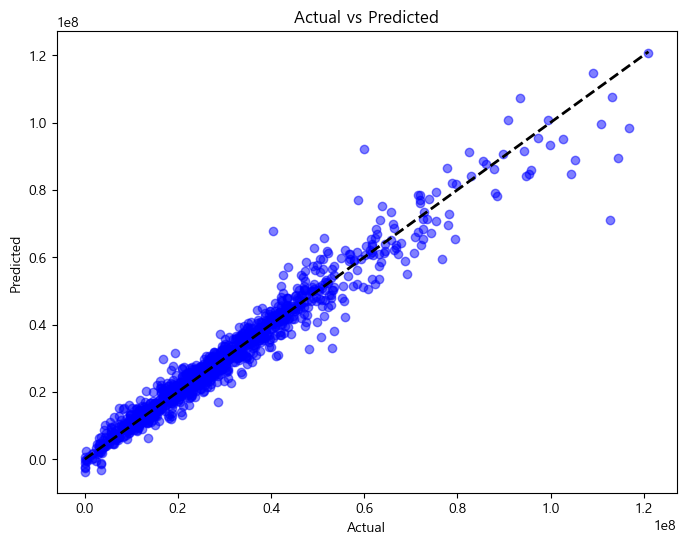

In [4]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

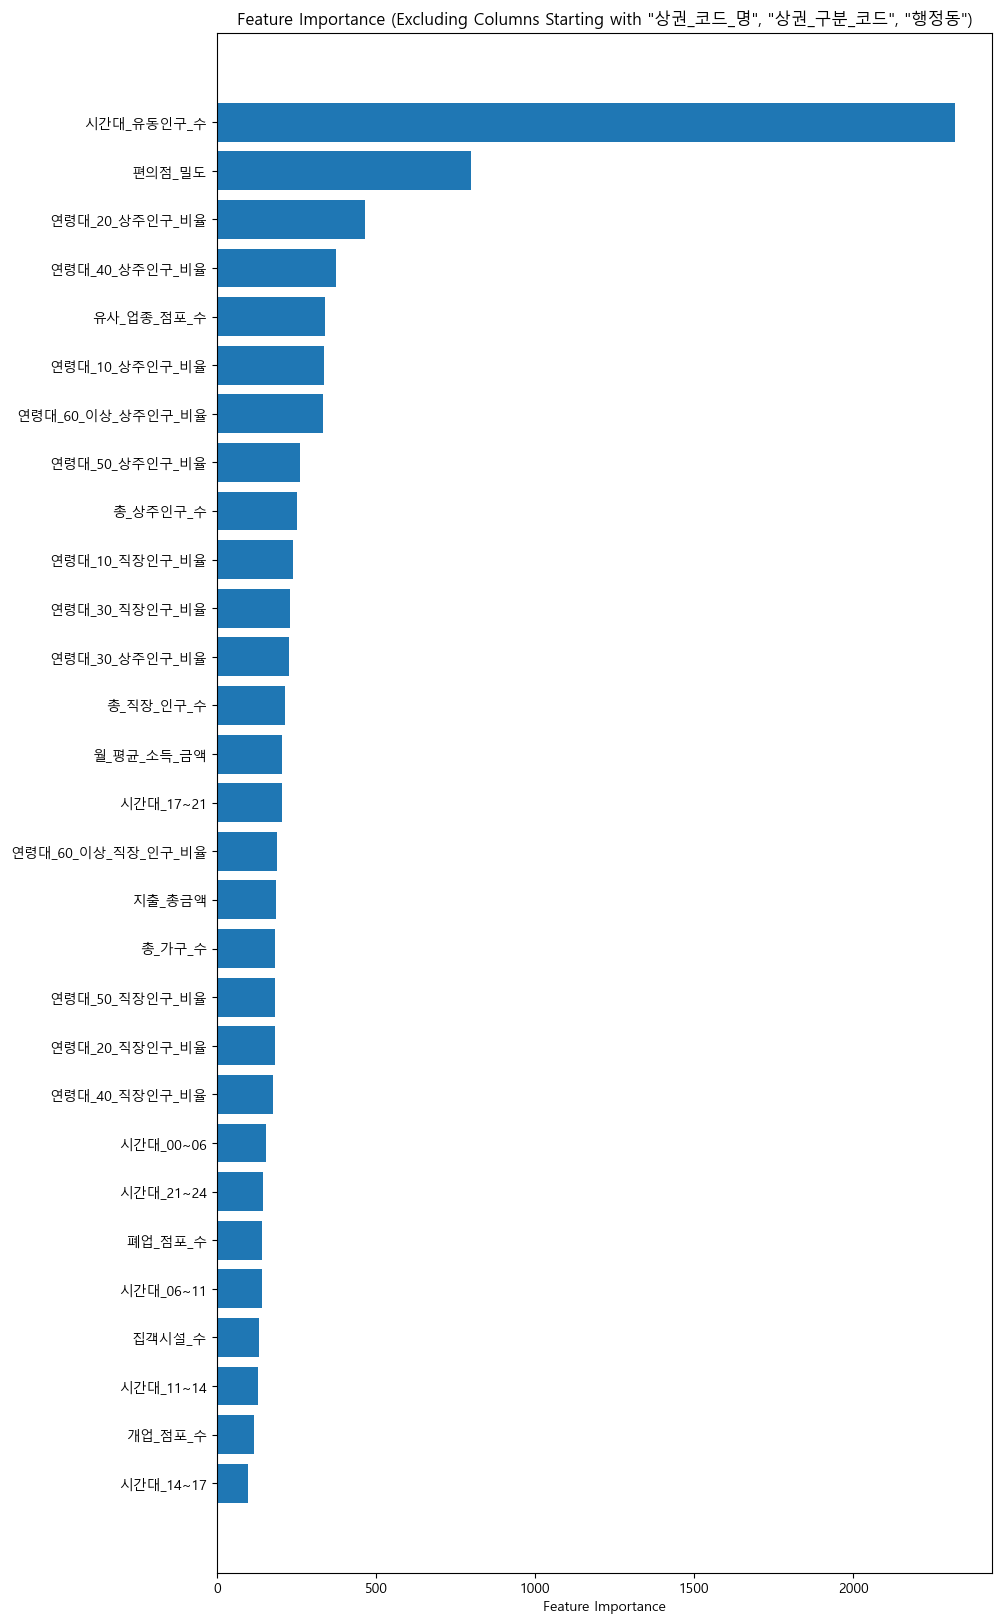

In [5]:
# 모델에서 피처 중요도 추출
feature_importance = best_lgbm_regression.feature_importances_

# 피처 중요도와 이름 추출
filtered_feature_importance = feature_importance[~X.columns.str.startswith(('상권_코드_명', '상권_구분_코드', '행정동', '기준'))]
filtered_feature_names = X.columns[~X.columns.str.startswith(('상권_코드_명', '상권_구분_코드', '행정동', '기준'))]

# 중요도가 높은 순으로 피처를 정렬
sorted_idx = np.argsort(filtered_feature_importance)[::-1]

# 피처 중요도 시각화
plt.figure(figsize=(10, 20))
plt.barh(range(len(filtered_feature_importance)), filtered_feature_importance[sorted_idx], align='center')
plt.yticks(range(len(filtered_feature_importance)), filtered_feature_names[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Feature Importance (Excluding Columns Starting with "상권_코드_명", "상권_구분_코드", "행정동")')
plt.gca().invert_yaxis()  # 상위 피처가 상단에 오도록 역순으로 설정
plt.show()


In [6]:
# 개업 점포 수가 가장 낮은 피처 제거 후 모델링

In [7]:
import warnings
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

# 경고 무시
warnings.filterwarnings("ignore")

# 폰트 설정
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')

data = pd.read_csv('data/final_merged_update_store_age_df.csv')

# 새로운 피처 추가
data['시간대_매출금액'] = data['시간대_매출금액']/data['유사_업종_점포_수']
data['편의점_밀도'] = data['유사_업종_점포_수']/data['영역_면적']

# 불필요한 컬럼 제거
data = data.drop(columns=['영역_면적', '상권_코드', '자치구_코드', '행정동_코드', '자치구_코드_명', '평일_유동인구_수_평균', '주말_유동인구_수_평균', '소득_구간_코드', '점포_수', '개업_율', '폐업_률', '프랜차이즈_점포_수', '개업_점포_수'])

# 범주형 변수와 숫자형 변수 구분
cat_cols = ['기준_년', '기준_분기', '시간대', '상권_구분_코드_명', '상권_코드_명', '행정동_코드_명']

# 독립변수와 종속변수 분리
y = data.pop('시간대_매출금액')
X = data

## 범주형 변수 더미화
X = pd.get_dummies(X, columns=cat_cols)

## 더미 변수화된 값이 불리언 형태로 나왔다면 0과 1로 변환
X.replace({True: 1, False: 0}, inplace=True)

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

def clean_feature_names(X):
    # 특수 문자를 제거하고 언더스코어(_)로 대체합니다.
    X.columns = [re.sub(r'\W+', '_', col) for col in X.columns]
    return X

# 데이터프레임 X의 특성 이름을 정제합니다.
X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)


# 모델 학습 - LightGBM
lgbm_regression = LGBMRegressor(random_state=42)

# 탐색할 하이퍼파라미터 범위 설정
param_grid = {
    'num_leaves': [25, 30, 35],
    'learning_rate': [0.12, 0.13, 0.14],
    'n_estimators': [375, 400, 425]
}

# GridSearchCV 객체 생성
grid_search = GridSearchCV(estimator=lgbm_regression, param_grid=param_grid, cv=3)

# 모델 학습
grid_search.fit(X_train, y_train)

# 최적의 모델로 예측 수행
best_lgbm_regression = grid_search.best_estimator_
y_pred = best_lgbm_regression.predict(X_test)

# 평가
def evaluate(y_true, y_pred):
    # MSE 계산
    mse = mean_squared_error(y_true, y_pred)
    
    # MAE 계산
    mae = mean_absolute_error(y_true, y_pred)
    
    # R-squared 계산
    r_squared = r2_score(y_true, y_pred)
    
    # RMSE 계산
    rmse = np.sqrt(mse)
    
    return {
        'MSE': mse,
        'MAE': mae,
        'R-squared': r_squared,
        'RMSE': rmse
    }


evaluate(y_test, y_pred)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2184
[LightGBM] [Info] Number of data points in the train set: 1834, number of used features: 117
[LightGBM] [Info] Start training from score 29772494.993898
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2186
[LightGBM] [Info] Number of data points in the train set: 1834, number of used features: 117
[LightGBM] [Info] Start training from score 30178658.439744
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2189
[LightGBM] [Info] Number of data points in the train set: 1834, number of used features: 117
[LightGBM] [I

{'MSE': 17498586777494.871,
 'MAE': 2635916.457334508,
 'R-squared': 0.9526873564034903,
 'RMSE': 4183131.216863137}

In [8]:
import warnings
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

# 경고 무시
warnings.filterwarnings("ignore")

data = pd.read_csv('data/final_merged_update_store_age_df.csv')

# 새로운 피처 추가
data['시간대_매출금액'] = data['시간대_매출금액'] / data['유사_업종_점포_수']
data['편의점_밀도'] = data['유사_업종_점포_수'] / data['영역_면적']

# 불필요한 컬럼 제거
data = data.drop(columns=['영역_면적', '상권_코드', '자치구_코드', '행정동_코드', '자치구_코드_명', '평일_유동인구_수_평균', '주말_유동인구_수_평균', '소득_구간_코드', '점포_수', '개업_율', '폐업_률', '프랜차이즈_점포_수'])

# 범주형 변수와 숫자형 변수 구분
cat_cols = ['기준_년', '기준_분기', '시간대', '상권_구분_코드_명', '상권_코드_명', '행정동_코드_명']

# 독립변수와 종속변수 분리
y = data.pop('시간대_매출금액')
X = data

## 범주형 변수 더미화
X = pd.get_dummies(X, columns=cat_cols)

## 더미 변수화된 값이 불리언 형태로 나왔다면 0과 1로 변환
X.replace({True: 1, False: 0}, inplace=True)

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

def clean_feature_names(X):
    # 특수 문자를 제거하고 언더스코어(_)로 대체합니다.
    X.columns = [re.sub(r'\W+', '_', col) for col in X.columns]
    return X

# 데이터프레임 X의 특성 이름을 정제합니다.
X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)

# 모델 학습 - Decision Tree
decision_tree_regression = DecisionTreeRegressor(random_state=42)
decision_tree_regression.fit(X_train, y_train)

# 최적의 모델로 예측 수행
y_pred = decision_tree_regression.predict(X_test)

# 평가
def evaluate(y_true, y_pred):
    # MSE 계산
    mse = mean_squared_error(y_true, y_pred)
    
    # MAE 계산
    mae = mean_absolute_error(y_true, y_pred)
    
    # R-squared 계산
    r_squared = r2_score(y_true, y_pred)
    
    # RMSE 계산
    rmse = np.sqrt(mse)
    
    return {
        'MSE': mse,
        'MAE': mae,
        'R-squared': r_squared,
        'RMSE': rmse
    }

evaluate(y_test, y_pred)


{'MSE': 46855348819392.71,
 'MAE': 4366129.648068204,
 'R-squared': 0.8733126024706646,
 'RMSE': 6845096.69905347}